In [1]:
import os
import torch
import matplotlib.pyplot as plt
from monai.apps import download_and_extract

# 절대 경로 사용
root_dir = os.path.expanduser("~/projects/monai/data")
os.makedirs(root_dir, exist_ok=True)

# 샘플 데이터 다운로드 (Spleen CT)
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
download_and_extract(resource, output_dir=root_dir)

print("✅ 데이터 다운로드 완료!")
print(f"📁 저장 위치: {root_dir}")

<frozen importlib._bootstrap_external>:1184: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
Task09_Spleen.tar: 1.50GB [13:03, 2.05MB/s]                                                                                                                           

2026-02-04 04:44:08,954 - INFO - Downloaded: /mnt/workspace/tmp/tmpi_5sod5e/Task09_Spleen.tar
2026-02-04 04:44:08,955 - INFO - Expected md5 is None, skip md5 check for file /mnt/workspace/tmp/tmpi_5sod5e/Task09_Spleen.tar.
2026-02-04 04:44:08,955 - INFO - Writing into directory: /home/gotree94/projects/monai/data.


✅ 데이터 다운로드 완료!
📁 저장 위치: /home/gotree94/projects/monai/data


📊 CT 이미지 수: 41
📊 라벨 수: 41

📐 이미지 shape: torch.Size([512, 512, 55])
📐 라벨 shape: torch.Size([512, 512, 55])


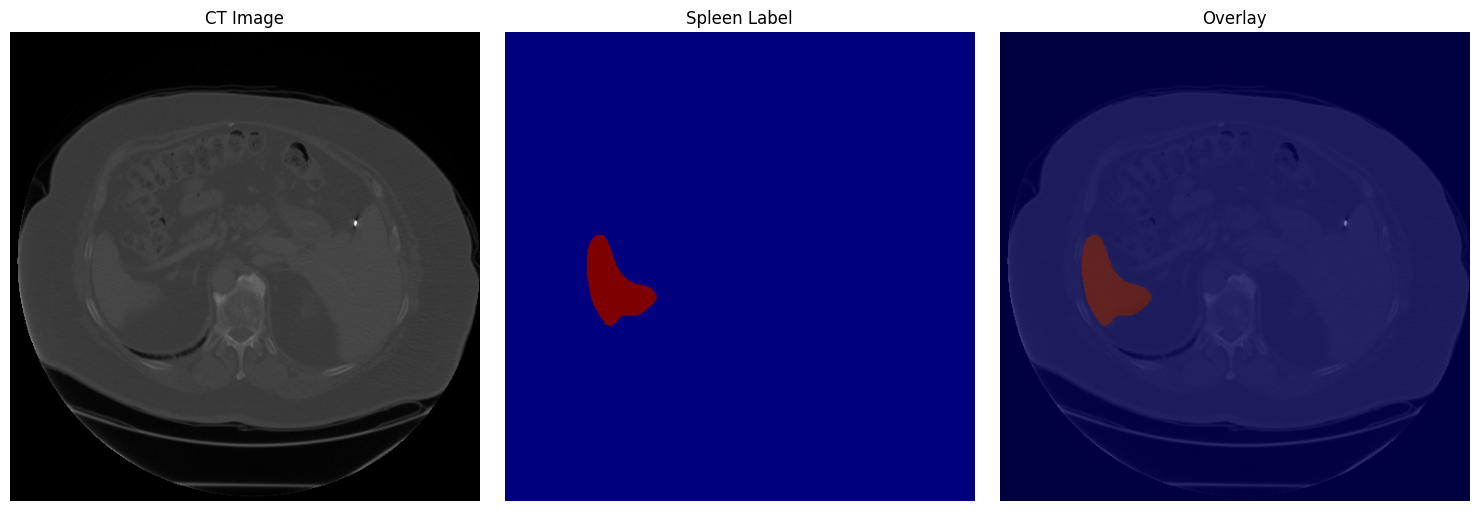


✅ 시각화 완료! 저장: ~/projects/monai/spleen_visualization.png


In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import LoadImage

# 데이터 경로
data_dir = os.path.expanduser("~/projects/monai/data/Task09_Spleen")
images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))

print(f"📊 CT 이미지 수: {len(images)}")
print(f"📊 라벨 수: {len(labels)}")

# 첫 번째 이미지 로드
loader = LoadImage(image_only=True)
image = loader(images[0])
label = loader(labels[0])

print(f"\n📐 이미지 shape: {image.shape}")
print(f"📐 라벨 shape: {label.shape}")

# 중간 슬라이스 시각화
slice_idx = image.shape[2] // 2

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# CT 이미지
axes[0].imshow(image[:, :, slice_idx].T, cmap="gray", origin="lower")
axes[0].set_title("CT Image")
axes[0].axis("off")

# 세그멘테이션 라벨 (비장)
axes[1].imshow(label[:, :, slice_idx].T, cmap="jet", origin="lower")
axes[1].set_title("Spleen Label")
axes[1].axis("off")

# 오버레이
axes[2].imshow(image[:, :, slice_idx].T, cmap="gray", origin="lower")
axes[2].imshow(label[:, :, slice_idx].T, cmap="jet", alpha=0.5, origin="lower")
axes[2].set_title("Overlay")
axes[2].axis("off")

plt.tight_layout()
plt.savefig(os.path.expanduser("~/projects/monai/spleen_visualization.png"), dpi=150)
plt.show()

print("\n✅ 시각화 완료! 저장: ~/projects/monai/spleen_visualization.png")

In [4]:
import torch
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd,
    ScaleIntensityRanged, CropForegroundd,
    RandSpatialCropd, Resized, ToTensord
)
from monai.data import Dataset, DataLoader
import os
import glob

# 데이터 준비
data_dir = os.path.expanduser("~/projects/monai/data/Task09_Spleen")
images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))[:5]
labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))[:5]

data_dicts = [{"image": img, "label": lbl} for img, lbl in zip(images, labels)]

# 전처리 파이프라인 (수정됨)
transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    Resized(keys=["image", "label"], spatial_size=(96, 96, 48)),  # 크기 조정
    ToTensord(keys=["image", "label"]),
])

# 데이터 로더
dataset = Dataset(data=data_dicts, transform=transforms)
loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0)  # num_workers=0

# 모델, 손실함수, 옵티마이저
device = torch.device("cuda")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
).to(device)

loss_fn = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 학습 (10 에포크)
print("🚀 학습 시작...")
for epoch in range(10):
    model.train()
    epoch_loss = 0
    for batch in loader:
        inputs = batch["image"].to(device)
        labels = batch["label"].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/10, Loss: {epoch_loss/len(loader):.4f}")

print("\n✅ 학습 완료!")

# 모델 저장
torch.save(model.state_dict(), os.path.expanduser("~/projects/monai/spleen_unet.pth"))
print("💾 모델 저장: ~/projects/monai/spleen_unet.pth")

🚀 학습 시작...
Epoch 1/10, Loss: 0.6744
Epoch 2/10, Loss: 0.6719
Epoch 3/10, Loss: 0.6669
Epoch 4/10, Loss: 0.6646
Epoch 5/10, Loss: 0.6625
Epoch 6/10, Loss: 0.6598
Epoch 7/10, Loss: 0.6564
Epoch 8/10, Loss: 0.6551
Epoch 9/10, Loss: 0.6517
Epoch 10/10, Loss: 0.6507

✅ 학습 완료!
💾 모델 저장: ~/projects/monai/spleen_unet.pth


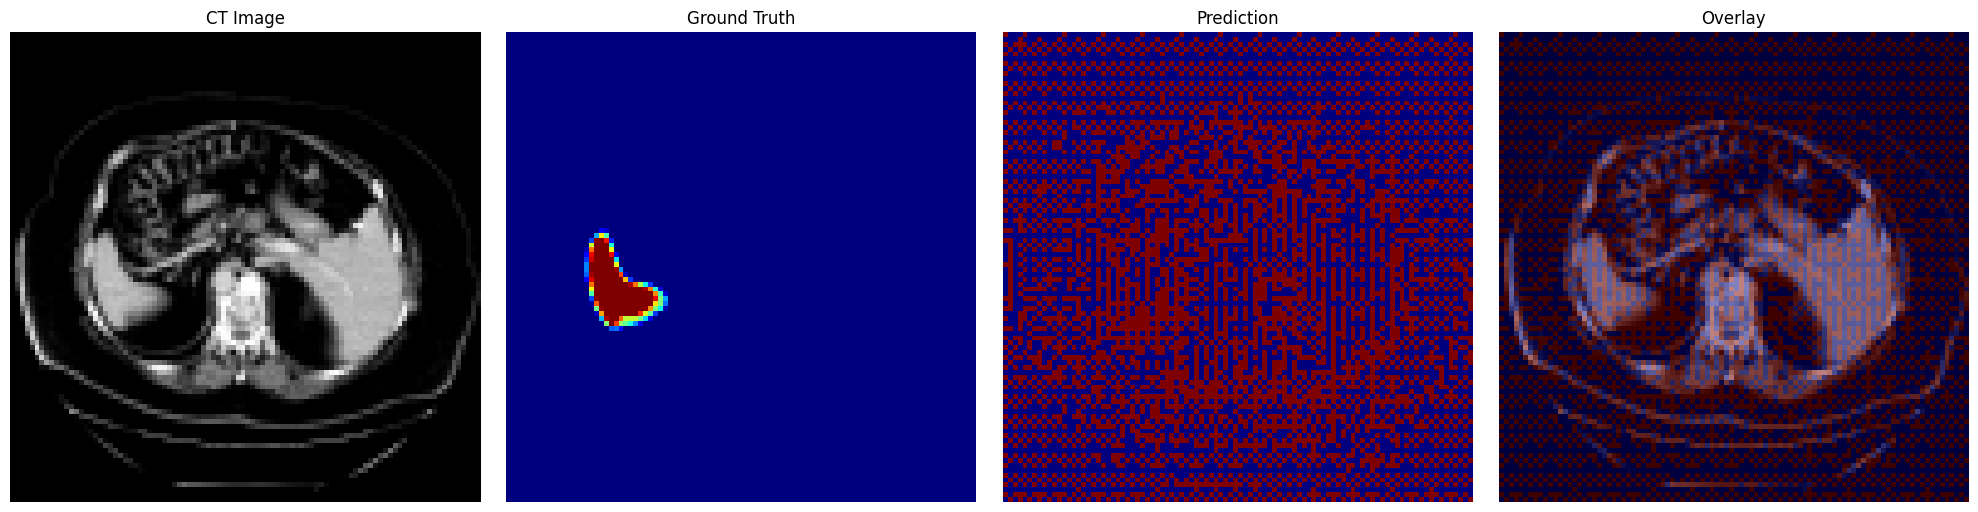


✅ 예측 시각화 완료!
💾 저장: ~/projects/monai/spleen_prediction.png


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from monai.networks.nets import UNet
from monai.transforms import Compose, LoadImage, EnsureChannelFirst, ScaleIntensityRange, Resize
from monai.inferers import sliding_window_inference
import os
import glob

# 모델 로드
device = torch.device("cuda")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
).to(device)
model.load_state_dict(torch.load(os.path.expanduser("~/projects/monai/spleen_unet.pth")))
model.eval()

# 테스트 이미지 로드
data_dir = os.path.expanduser("~/projects/monai/data/Task09_Spleen")
test_image = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))[0]
test_label = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))[0]

# 전처리
transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ScaleIntensityRange(a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    Resize(spatial_size=(96, 96, 48)),
])

image = transforms(test_image).unsqueeze(0).to(device)
label = Compose([LoadImage(image_only=True), EnsureChannelFirst(), Resize(spatial_size=(96, 96, 48))])(test_label)

# 예측
with torch.no_grad():
    output = model(image)
    pred = torch.argmax(output, dim=1).cpu().numpy()[0]

# 시각화
slice_idx = 24  # 중간 슬라이스

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 원본 이미지
axes[0].imshow(image.cpu().numpy()[0, 0, :, :, slice_idx].T, cmap="gray", origin="lower")
axes[0].set_title("CT Image")
axes[0].axis("off")

# 실제 라벨
axes[1].imshow(label.numpy()[0, :, :, slice_idx].T, cmap="jet", origin="lower")
axes[1].set_title("Ground Truth")
axes[1].axis("off")

# 예측 결과
axes[2].imshow(pred[:, :, slice_idx].T, cmap="jet", origin="lower")
axes[2].set_title("Prediction")
axes[2].axis("off")

# 오버레이
axes[3].imshow(image.cpu().numpy()[0, 0, :, :, slice_idx].T, cmap="gray", origin="lower")
axes[3].imshow(pred[:, :, slice_idx].T, cmap="jet", alpha=0.5, origin="lower")
axes[3].set_title("Overlay")
axes[3].axis("off")

plt.tight_layout()
plt.savefig(os.path.expanduser("~/projects/monai/spleen_prediction.png"), dpi=150)
plt.show()

print("\n✅ 예측 시각화 완료!")
print("💾 저장: ~/projects/monai/spleen_prediction.png")